# Entraîner un réseau Unet

Dans ce TD, nous allons créer et entraîner un réseau de neurones convolutionnel de type Unet. L'objectif est d'identifier les zones de cirrus et de cumulus sur une photo.

Le Unet permet de segmenter des images, en classifiant chaque pixel dans une catégorie.

In [4]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.path import Path
import matplotlib.image as mpimg
import csv
import json
import random

import keras
from keras import callbacks
from keras.models import *
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, Cropping2D, concatenate
from keras.optimizers import *

from keras import backend as keras_backend

## Annoter les images d'entraînement

Nous allons d'abord labelliser le jeu d'entraînement. Pour cela, nous allons utiliser l'outil VGG Image Annotator (VIA) pour délimiter chaque zone de nuage par un polygone.

Dans VIA, les polygones sont groupés par type, et portent chacun un label. Nous allons utiliser les noms suivants :
* Type : nuages
* Labels :
  * cirrus
  * cumulus

Lien de téléchargement de l'outil VIA :
http://www.robots.ox.ac.uk/~vgg/software/via/

Une fois les images annotées, récupérer les données sous forme d'un csv et le placer dans le dossier data.

## Lecture des données du fichier csv produit par VIA

Commençons par lire le fichier csv créé à l'aide de VGG Image Annotator. Nous allons mettre le contenu de ce fichier dans une liste `labels_data` dont chaque élément contient les informations suivantes :
* nom de fichier
* label
* coordonnées du polygone

In [5]:
# Lit le fichier csv créé à l'aide de VGG Image Annotator
# et créée une liste labels_data dont chaque élément contient les informations suivantes :
# nom de fichier, label, coordonnées du polygone

labels_filename = "via_region_data.csv"

width = 320
height = 240

labels_data = []

with open(labels_filename) as csvfile:
    csvreader = csv.DictReader(csvfile)
    i = 0
    for row in csvreader:
        filename = row['filename']
        try:
            all_points_x = json.loads(row['region_shape_attributes'])['all_points_x']
            all_points_y = json.loads(row['region_shape_attributes'])['all_points_y']
            # Récupère les polygones de neige
            label = json.loads(row['region_attributes'])['Chess']
            
            # Add data to list
            labels_data.append({
                'filename': filename,
                'all_points_x': all_points_x,
                'all_points_y': all_points_y,
                'label': label
            })
            
            # Count data
            i += 1

        except KeyError:
            all_points_x = []
            all_points_y = []
            label = ""
print (i, "data found.")
print ("labels_data list created.")

668 data found.
labels_data list created.


Regardons à quoi ressemble un élément de la liste labels_data.

## Création des masques

En sortie, le Unet va produire des masques contenant, pour chaque pixel, une valeur entre 0 et 1 indiquant la probabilité d'appartenance à la classe.

Dans notre exemple, le Unet va produire un masque pour les cirrus et un autre pour les cumulus.

Il faut donc créer ces masques à partir des polygones.

Commençons par écrire une fonction qui génère un masque sous la forme d'un matrice numpy à partir d'un polygone.

In [6]:
# Function to plot a polygon on a mask
# Input : list of points (x and y), width and height of the mask
# Returns a numpy array (0 for points out of the polygon, 1 for points in the polygon)
def create_mask_polygon(all_points_x, all_points_y, width, height):
    mask_shape = (height, width)
    points = np.indices(mask_shape).reshape(2, -1).T
    verts = np.array((all_points_y, all_points_x)).T
    path = Path(verts)
    mask = path.contains_points(points, radius=1e-9)
    mask = mask.reshape(mask_shape).astype('int')
    return mask

Créons maintenant un masque pour chaque polygone de labels_data, et mettons le résultat dans labels_data.

In [7]:
images_dir = './data/train/'

# Create masks in labels_data
for elt in labels_data:
    # Get data
    all_points_x = elt['all_points_x']
    all_points_y = elt['all_points_y']
    img_path = images_dir + elt['filename']
    img = mpimg.imread(img_path)
    img_height = img.shape[0]
    img_width = img.shape[1]
    # Plot polygon on mask
    mask = create_mask_polygon(np.array(all_points_x) * width / img_width, np.array(all_points_y) * height / img_height, width, height)
    #mask = create_mask_polygon(np.array(all_points_x), np.array(all_points_y), img_width, img_height)
    elt['mask'] = mask

Visualisons une image et un masque.

/home/simon/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


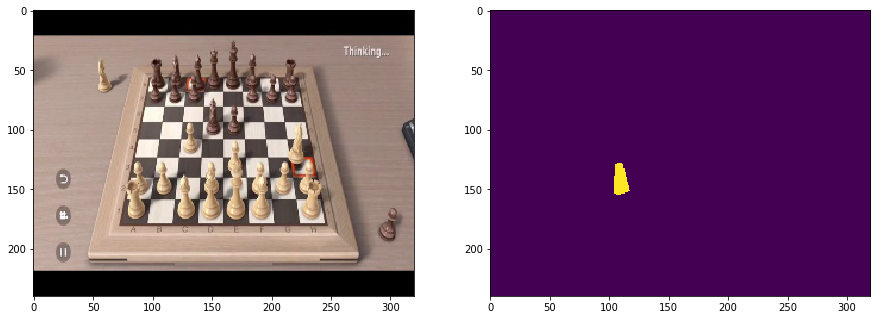

In [8]:
from skimage.transform import resize

num_label = 6

images_dir = './data/train/'

f,ax = plt.subplots(1,2, figsize=(15, 8))

mask = labels_data[num_label]['mask']

img = mpimg.imread(images_dir + labels_data[num_label]['filename'])

img = resize(img, (height, width))

ax[0].imshow(img)
ax[1].imshow(mask)
plt.show()

Chaque polygone a maintenant son masque. Nous pouvons donc préparer le jeu de données sous la forme X, y.

Attention, chaque image peut avoir plusieurs polygones. Dans ce cas, il faut fusionner les masques de chaque polygone.

In [9]:
### Create X and y dataset

nb_y_features = 7

### Create filename list

filenames = []

for elt in labels_data:
    filename = elt['filename']
    if filename not in filenames:
        filenames.append(filename)
    
### Create X and y dataset

X = []
y = []
for filename in filenames:
    # Load image
    image = mpimg.imread(images_dir + filename)
    image = resize(image, (height, width))
    X.append(image)
    
    # Load masks
    zero_mask = np.zeros((height, width))
    masks = [zero_mask for i in range(nb_y_features)]
    for elt in labels_data:
        if elt['filename'] == filename:
            if elt['label'] == 'board':
                masks[0] = np.logical_or((masks[0] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'queen':
                masks[1] = np.logical_or((masks[1] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'king':
                masks[2] = np.logical_or((masks[2] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'pawn':
                masks[3] = np.logical_or((masks[3] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'bishop':
                masks[4] = np.logical_or((masks[4] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'knight':
                masks[5] = np.logical_or((masks[5] > 0), (elt['mask'] > 0)).astype('int')
            elif elt['label'] == 'tower':
                masks[6] = np.logical_or((masks[6] > 0), (elt['mask'] > 0)).astype('int')
                
    # Replace empty masks by zeros mask
    for i in range(0,nb_y_features):
        if masks[i] is None:
            masks[i] = np.zeros((height, width))
    y.append(masks)

X = (np.array(X) * 255).astype(np.uint8)
y = np.array(y).swapaxes(1,3).swapaxes(1,2).astype(np.uint8)

/home/simon/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


## Vérifions que X et y sont corrects

Regardons les dimensions de X et y.

In [10]:
X.shape

(32, 240, 320, 3)

In [11]:
y.shape

(32, 240, 320, 7)

In [12]:
np.save('X.npy', X)
np.save('y.npy', y)

Affichons un élément du jeu de données.

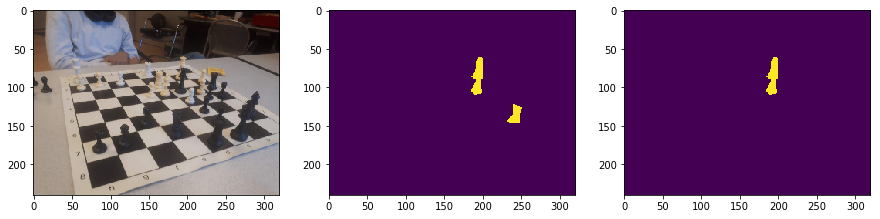

In [42]:
sample_number = 5

f,ax = plt.subplots(1,3, figsize=(15, 8))

img = X[sample_number]
mask_discontinue = y[sample_number, :, :, 3]
mask_continue = y[sample_number, :, :, 1]

ax[0].imshow(img)
ax[1].imshow(mask_discontinue)
ax[2].imshow(mask_continue)
plt.show()

OK. Tout a l'air bon !

## Création de train / val

Découpons le jeu de données en train / val.

In [43]:
nb_train = 19

In [44]:
nb_val = X.shape[0] - nb_train
X_train = X[0:nb_train, :,:,:]
y_train = y[0:nb_train, :,:,:]
X_val = X[nb_train: nb_train+nb_val, :,:,:]
y_val = y[nb_train: nb_train+nb_val, :,:,:]

## Facultatif: Data augmentation

A ce stade, nous avons déjà les données nécessaires pour entraîner notre Unet.

Mais nous allons tout de même passer encore un peu de temps sur la préparation des données. Comme nous l'avons déjà vu, la *data augmentation* peut permettre d'accroître la robustesse de notre modèle.

Créons donc un générateur qui va renvoyer de batchs de données augmentées. Pour chaque sample, le générateur va effectuer quelques transformations : rotation, décalage, zoom.

In [45]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, X, y, batch_size=1, augmentation = True):
        'Initialization'
        self.batch_size = batch_size
        self.X = X
        self.y = y
        self.indexes = None
        self.currentIndex = 0
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        data_index_min = int(index*self.batch_size)
        data_index_max = int(min((index+1)*self.batch_size, len(self.indexes)))
        indexes = self.indexes[data_index_min:data_index_max]

        this_batch_size = len(indexes) # The last batch can be smaller than the others
        X = np.empty((this_batch_size, height, width, 3), dtype=int)
        y = np.empty((this_batch_size, height, width, nb_y_features), dtype=int)
        
        for i, sample_index in enumerate(indexes):
            data_index = self.indexes[index * self.batch_size + i]
            X_sample, y_sample = self.X[data_index].copy(), self.y[data_index]
            
            sample = np.concatenate((X_sample, y_sample), axis = 2).astype(np.uint8)
            
            if self.augmentation:
                # Augmentation: rotate, translate...
                sample = tf.keras.preprocessing.image.random_rotation(sample, 15, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
                sample = tf.contrib.keras.preprocessing.image.random_shift(sample, 0.2, 0.2, row_axis=0, col_axis=1, channel_axis=2, fill_mode='constant')
                sample = tf.contrib.keras.preprocessing.image.random_zoom(sample, (0.9, 0.9), row_axis=0, col_axis=1, channel_axis=2)
                
            X[i, ...] = sample[:, :, :3]
            y[i, ...] = sample[:, :, 3:(nb_y_features + 3)]
        
        # Return result
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'        
        self.indexes = list(range(len(self.X)))
        np.random.shuffle(self.indexes)

NameError: name 'keras' is not defined

Testons notre générateur pour voir à quoi ressemblent les données créées.

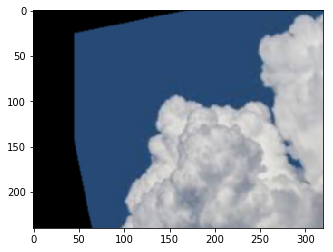

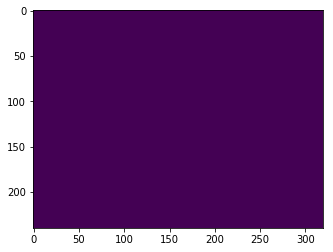

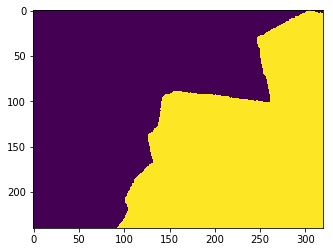

In [14]:
# Testing data generator
batch_nb = 1
img_nb = 2
test_generator = DataGenerator(X_train, y_train, batch_size=3)
Xtest, ytest = test_generator.__getitem__(batch_nb)
plt.imshow(Xtest[img_nb, ...])
plt.show()
plt.imshow(ytest[img_nb, :,:,0])
plt.show()
plt.imshow(ytest[img_nb, :,:,1])
plt.show()

## Création du modèle

Grâce à la librairie keras, il est assez simple d'écrire notre propre Unet. Mais comme c'est un peu fastidieux, une rapide recherche sur google permet de trouver des codes keras déjà prêts.

Le code ci-dessous est inspiré d'une implémentation du Unet trouvée sur github. Il a été modifié, en particulier pour supprimer des couches et diminuer le nombre de filtres afin d'accélérer l'entraînement sur une machine sans GPU. En conditions réelles, il faudrait bien entendu remettre plus de couches et de filtres.

In [32]:
def get_unet():

    inputs = Input((height, width, 3))

    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    #conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    #print("conv3 shape:",conv3.shape)
    #conv3 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    #print("conv3 shape:",conv3.shape)
    #pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #print("pool3 shape:",pool3.shape)

    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    #conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    #up7 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    #merge7 = concatenate([conv3,up7], axis = 3)
    #conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    #conv7 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
    
    up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    #up8 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    #conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    # Changed to learn 2 features
    conv9 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(2, 1, activation = 'sigmoid')(conv9)

    
    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [33]:
keras_backend.clear_session()
seq = get_unet()

/home/dl-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


La méthode `summary` de keras permet de visualiser quelques paramètres du réseau de neurones que nous venons de construire.

In [34]:
seq.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 240, 320, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 240, 320, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 240, 320, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 120, 160, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

## Entraînement du modèle

Nous pouvons utiliser tensorboard pour visualiser les courbes d'apprentissage pendant l'entraînement.

Pour lancer tensorboard, dans une console aller dans le répertoire du présent notebook, puis entrer : `tensorboard --logdir=logs`

In [35]:
# Set tensorboard logs
tensorboardCallback = callbacks.TensorBoard(log_dir='./logs/unet_2', histogram_freq=0,  
          write_graph=True, write_images=True)

C'est parti pour l'entraînement ! Sans GPU, ça sera long... Sur un GPU, ça se fait en quelques minutes, voire quelques dizaines de minutes pour obtenir des meilleurs résultats.

Afin de minimiser le temps de calcul sur CPU, nous allons faire l'impasse sur la Data Augmentation. Sur GPU, vous pouvez mettre `augmentation=True` dans le training_generator ci-dessous. Vous pouvez aussi commencer par entraîner sans data augmentation, puis ajouter la data augmentation avant que le modèle commence à overfitter. A vous de trouver l'alchimie qui fonctionnera le mieux !

In [42]:
# To train, set learning rate to 1e-5. It could be useful to lower after a few epochs towards 10e-8

# Set the learning rate
seq.optimizer.lr.assign(1e-5)

# Create generator
training_generator = DataGenerator(X_train, y_train, batch_size=4, augmentation=True)
testing_generator = DataGenerator(X_val, y_val, batch_size=1, augmentation=False)

# Train the model
seq.fit_generator(training_generator, epochs=1000, validation_data=testing_generator, callbacks=[tensorboardCallback])

Epoch 1/1000
7/7 [==============================] - 2s 228ms/step - loss: 0.0752 - acc: 0.9681 - val_loss: 0.8274 - val_acc: 0.8055
Epoch 2/1000
7/7 [==============================] - 1s 207ms/step - loss: 0.0654 - acc: 0.9731 - val_loss: 1.0020 - val_acc: 0.7918
Epoch 3/1000
7/7 [==============================] - 1s 187ms/step - loss: 0.0856 - acc: 0.9646 - val_loss: 0.9218 - val_acc: 0.7973
Epoch 4/1000
7/7 [==============================] - 1s 192ms/step - loss: 0.0858 - acc: 0.9644 - val_loss: 0.6905 - val_acc: 0.8184
Epoch 5/1000
7/7 [==============================] - 1s 205ms/step - loss: 0.0990 - acc: 0.9586 - val_loss: 0.8810 - val_acc: 0.7880
Epoch 6/1000
7/7 [==============================] - 2s 216ms/step - loss: 0.0782 - acc: 0.9677 - val_loss: 0.8367 - val_acc: 0.7958
Epoch 7/1000
7/7 [==============================] - 1s 203ms/step - loss: 0.0779 - acc: 0.9687 - val_loss: 0.9618 - val_acc: 0.7855
Epoch 8/1000
7/7 [==============================] - 1s 188ms/step - loss: 0.

In [43]:
#seq.save('model_unet4.h5')

In [53]:
seq = load_model('model_unet4.h5')

## Visualisation des résultats

Regardons les prédictions de notre modèle sur des images du jeu de validation.

In [54]:
import time

image_nb = 1

# Test on one image
image_val = X_val[image_nb,:,:,:]

t = time.time()
predicted_mask = seq.predict(image_val[np.newaxis,:,:,:])
print ("Prédiction effectuée en", time.time() - t, "secondes")

Prédiction effectuée en 0.22568249702453613 secondes


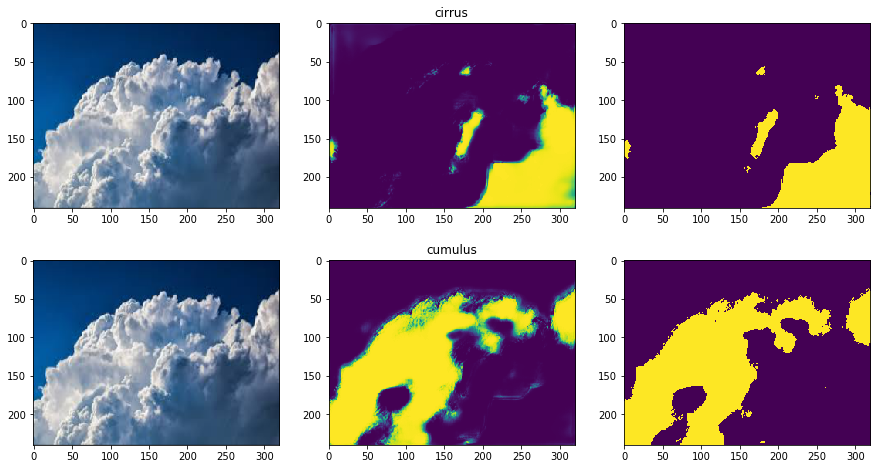

In [55]:
f, ax = plt.subplots(2,3)
f.set_figheight(8)
f.set_figwidth(15)
ax[0,0].imshow(image_val)
ax[0,1].imshow(predicted_mask[0,:,:,0], vmin=0, vmax=1)
ax[0,1].set_title("cirrus")
ax[0,2].imshow(predicted_mask[0,:,:,0] > 0.5)
ax[1,0].imshow(image_val)
ax[1,1].imshow(predicted_mask[0,:,:,1], vmin=0, vmax=1)
ax[1,1].set_title("cumulus")
ax[1,2].imshow(predicted_mask[0,:,:,1] > 0.5)


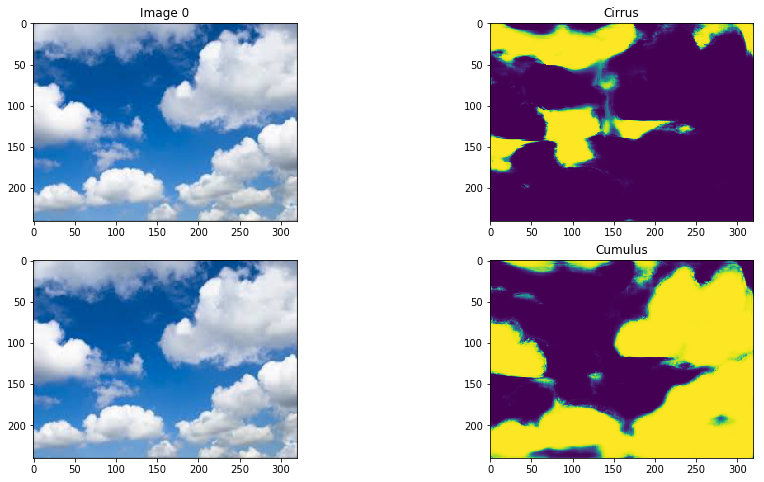

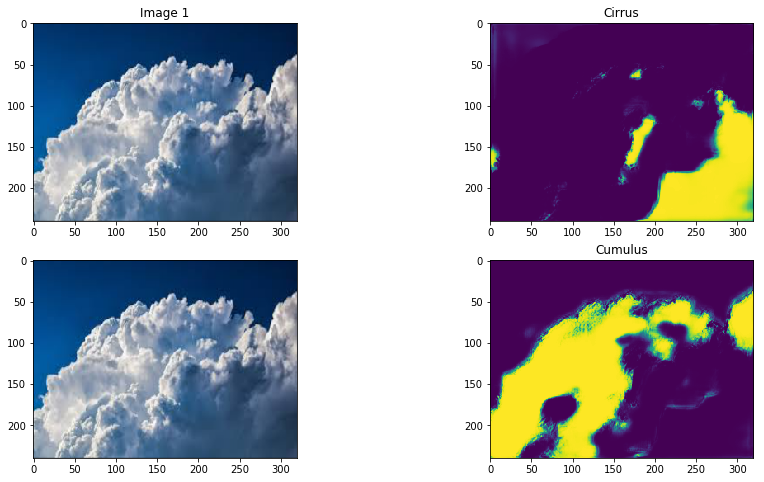

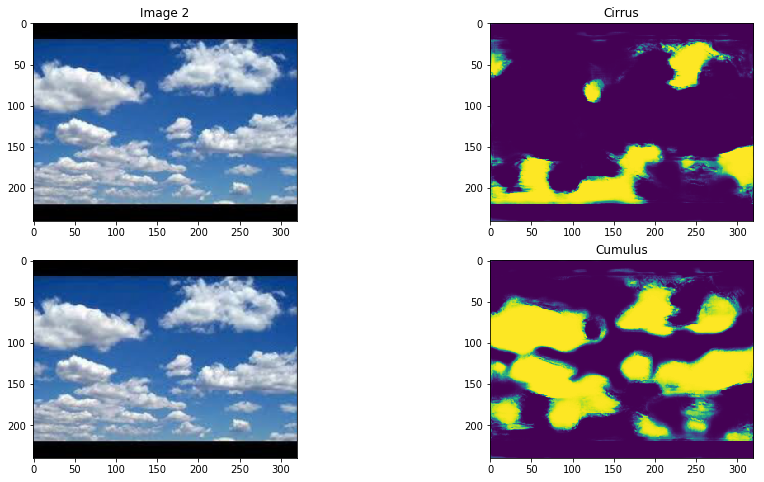

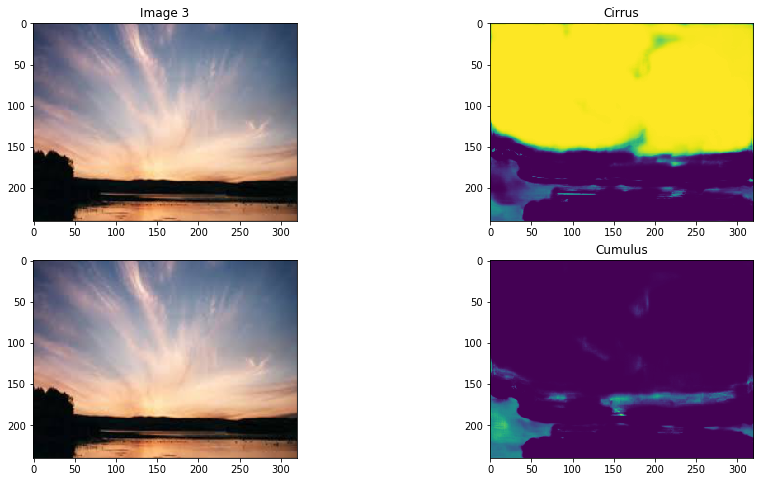

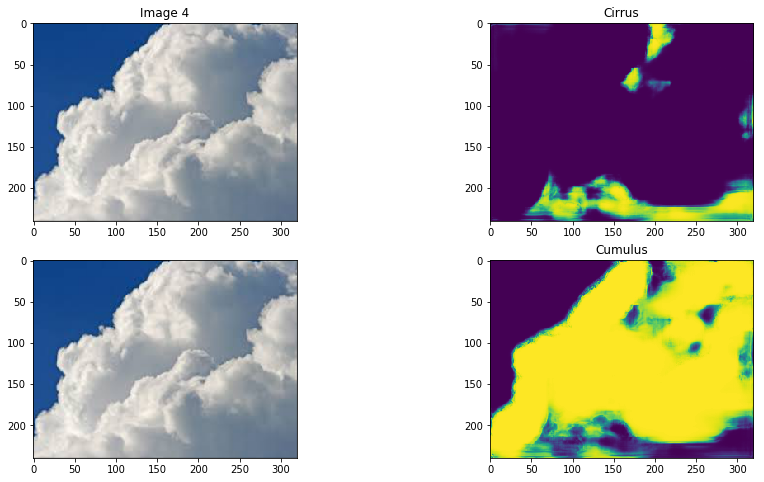

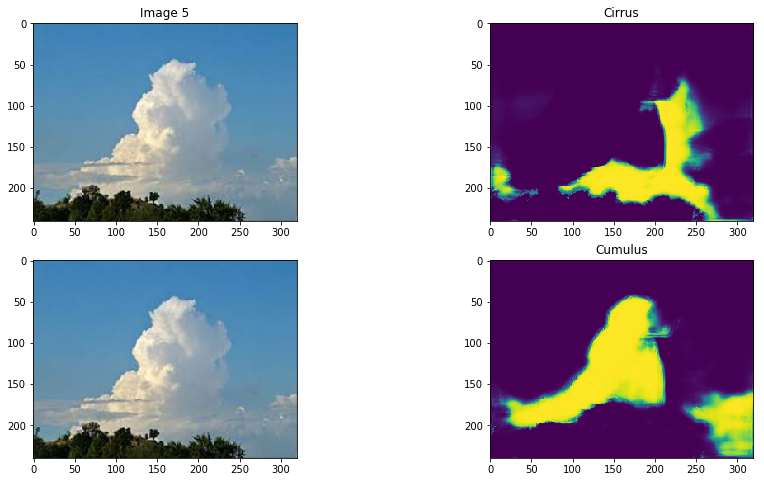

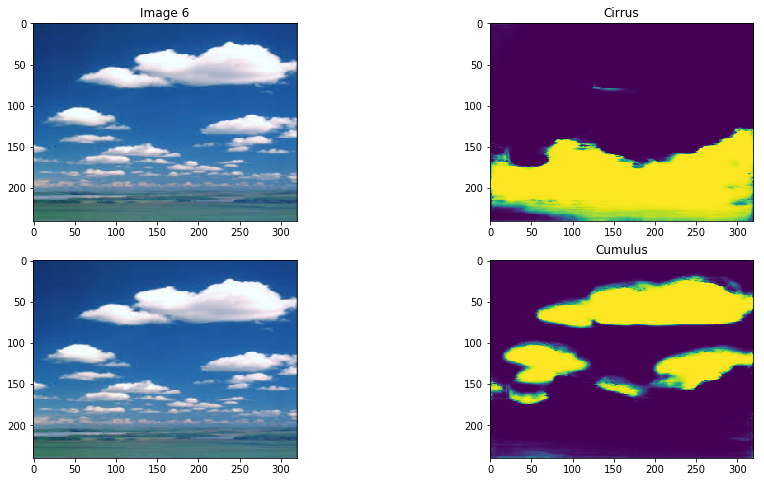

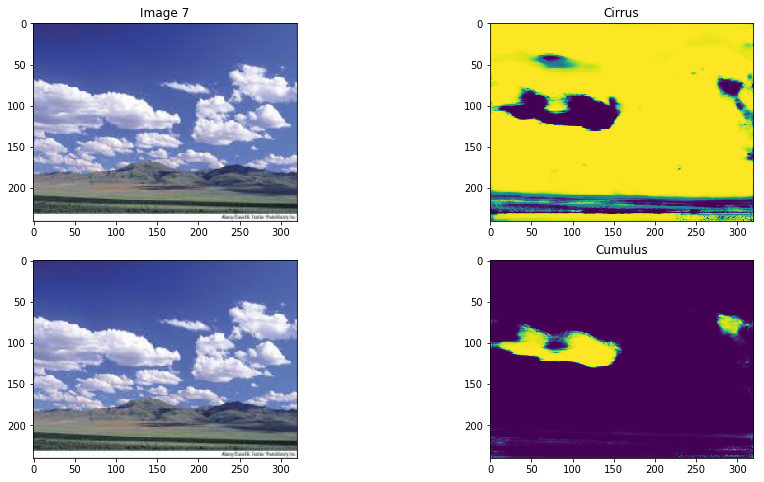

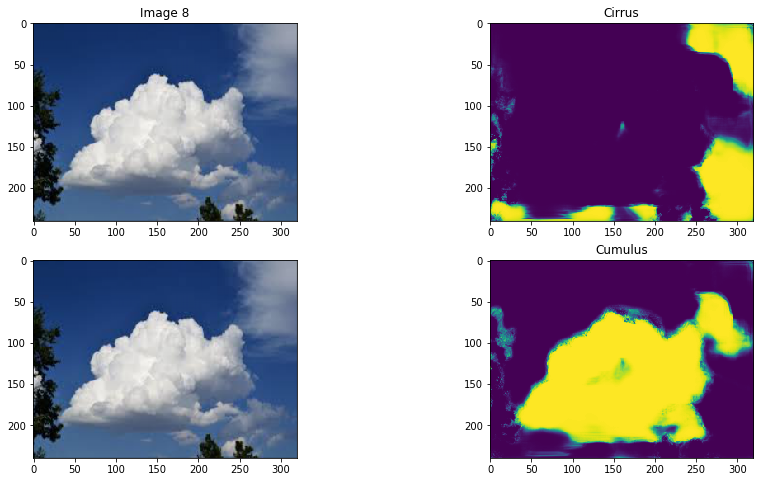

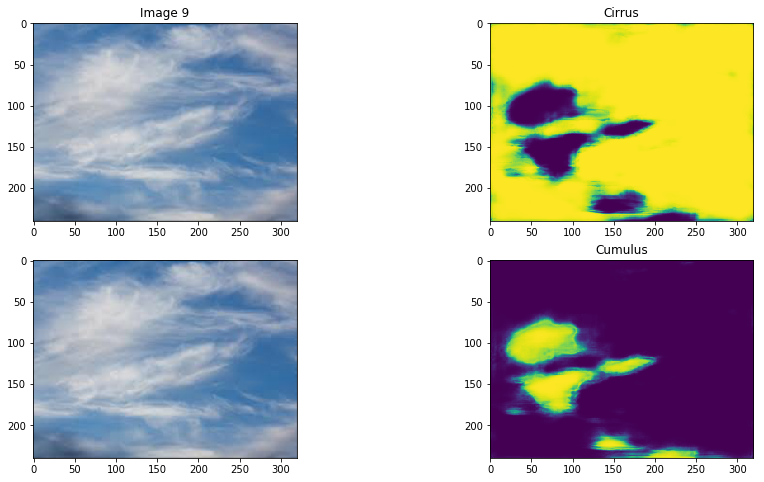

In [56]:
############################
# Draw all validation images
############################

# Iterate on validation images
for i in range(0,X_val.shape[0]):
    image_val = X_val[i,:,:,:].copy()
    # Predict masks
    predicted_mask = seq.predict(image_val[np.newaxis,:,:,:])
    
    f, ax = plt.subplots(2,2)
    f.set_figheight(8)
    f.set_figwidth(15)
    
    ax[0,0].imshow(image_val)
    ax[0,0].set_title("Image " + str(i))
    
    ax[0,1].imshow(predicted_mask[0,:,:,0], vmin=0, vmax=1)
    ax[0,1].set_title("Cirrus")
    
    ax[1,0].imshow(image_val)
    ax[1,1].imshow(predicted_mask[0,:,:,1], vmin=0, vmax=1)
    ax[1,1].set_title("Cumulus")